# Imports

In [65]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn import metrics

from sklearn.metrics import mean_squared_error
from math import sqrt

# data visualization 
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

#modeling
from statsmodels.tsa.api import Holt

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import acquire1
import prepare1


Using tore_item_sales

In [2]:
store = acquire1.get_store_data()

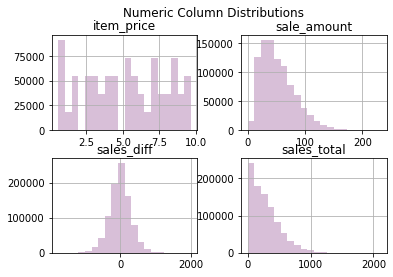

In [3]:
store = prepare1.prepped_store_df()

In [4]:
store.head(2)

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,month,weekday,sales_total,sales_diff
sale_date,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,1,Tuesday,10.92,NaN
2013-01-01 00:00:00+00:00,26.0,211817,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,1,Tuesday,218.40,207.48


In [5]:
df = store[["sale_amount", "sales_total"]]

In [6]:
df.rename(columns={"sale_amount": "items_sold"}, inplace=True)

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [7]:
train_size = int(len(df) * .5)
val_size = int(len(df) * .3)
test_size = int(len(df) - train_size - val_size)

In [8]:
print(train_size)
print(val_size)
print(test_size)
print(train_size + val_size)

456500
273900
182600
730400


In [9]:
val_end_index = train_size + val_size
val_end_index

730400

In [10]:
train = df[:train_size]
validate = df[train_size : val_end_index]
test = df[val_end_index:]

In [11]:
train.head()

,items_sold,sales_total
sale_date,,
2013-01-01 00:00:00+00:00,13.0,10.92
2013-01-01 00:00:00+00:00,26.0,218.40
2013-01-01 00:00:00+00:00,27.0,125.55
2013-01-01 00:00:00+00:00,54.0,453.60
2013-01-01 00:00:00+00:00,35.0,294.00


In [12]:
train.shape

(456500, 2)

In [13]:
validate.head()

,items_sold,sales_total
sale_date,,
2015-07-03 00:00:00+00:00,31.0,186.31
2015-07-03 00:00:00+00:00,105.0,544.95
2015-07-03 00:00:00+00:00,80.0,314.40
2015-07-03 00:00:00+00:00,53.0,61.48
2015-07-03 00:00:00+00:00,47.0,28.20


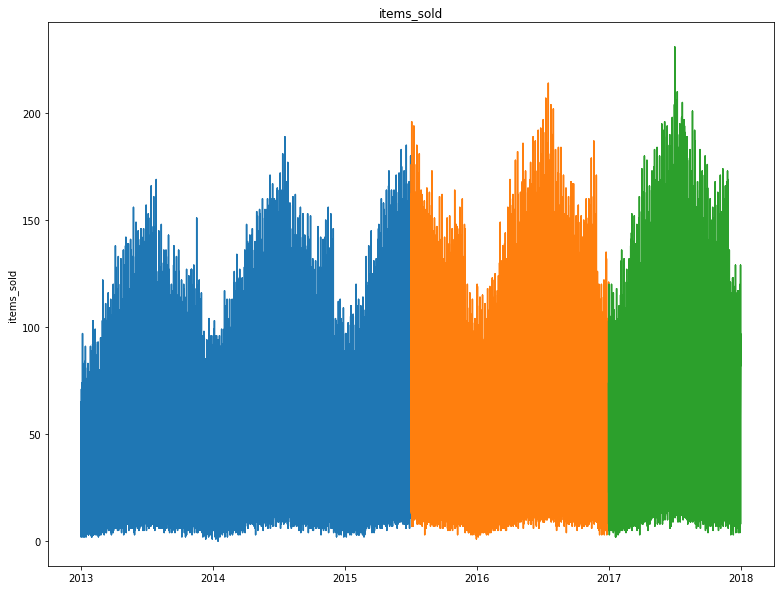

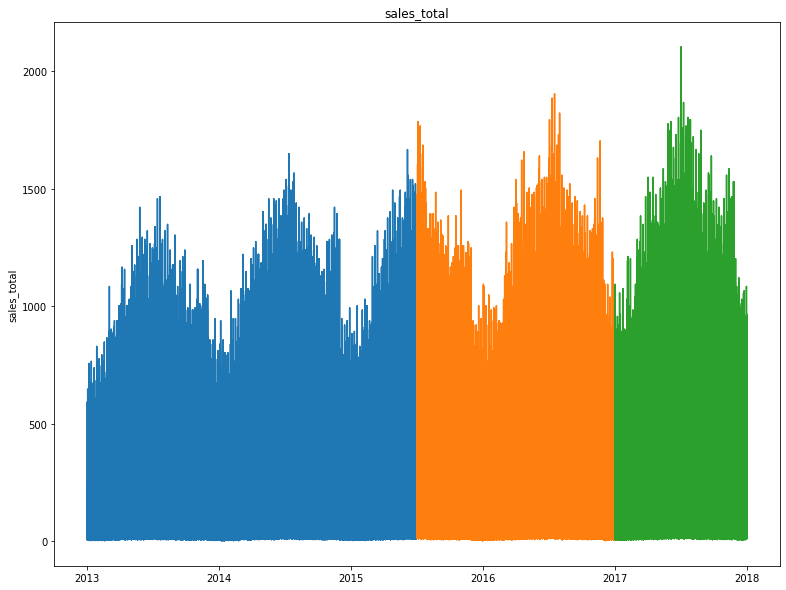

In [14]:
#Validate splits
for col in train.columns:
    plt.figure(figsize=(13,10))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show


In [15]:
df = df.resample("W").sum()
train = train.resample("W").sum()
validate = validate.resample("W").sum()
test = test.resample("W").sum()

2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

# Simple Average

In [44]:
items = round(train["items_sold"].mean(), 2)
dollars = round(train["sales_total"].mean(), 2)

In [45]:
def make_predictions():
    yhat_df = pd.DataFrame({"items_sold": [items],
                           "sales_total": [dollars]},
                          index = validate.index)
    return yhat_df

In [46]:
yhat_df = make_predictions()

In [47]:
yhat_df

,items_sold,sales_total
sale_date,,
2015-07-05 00:00:00+00:00,165373.25,889116.94
2015-07-12 00:00:00+00:00,165373.25,889116.94
2015-07-19 00:00:00+00:00,165373.25,889116.94
2015-07-26 00:00:00+00:00,165373.25,889116.94
2015-08-02 00:00:00+00:00,165373.25,889116.94
...,...,...
2016-12-04 00:00:00+00:00,165373.25,889116.94
2016-12-11 00:00:00+00:00,165373.25,889116.94
2016-12-18 00:00:00+00:00,165373.25,889116.94


## Plot Actual VS Predicted

In [48]:
def evaluate_rmse(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [49]:
def plot_and_evaluate(target_variable):
    plt.figure(figsize=(13,10))
    plt.plot(train[target_variable], label = "Train", linewidth = 1)
    plt.plot(validate[target_variable], label = "Validate", linewidth = 1)
    plt.plot(yhat_df[target_variable])
    plt.title(target_variable)
    rmse = evaluate_rmse(target_variable)
    print(target_variable, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    

items_sold -- RMSE: 45484


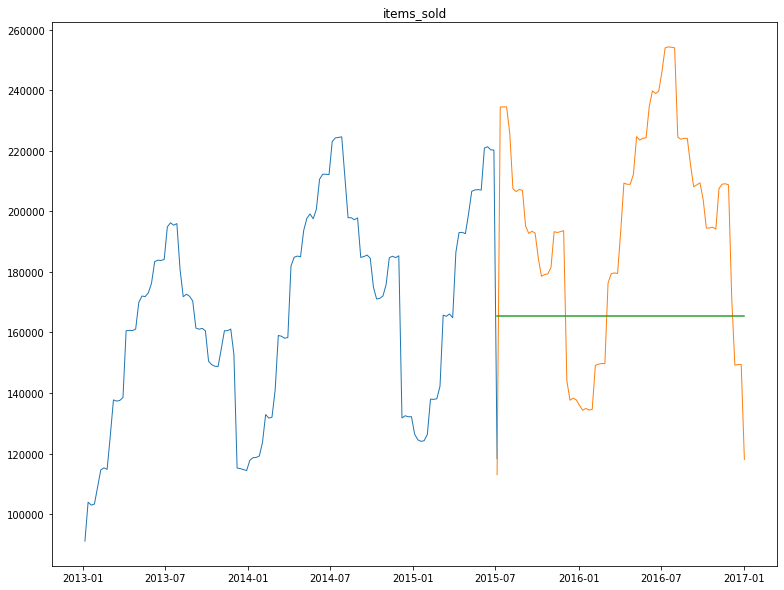

sales_total -- RMSE: 244426


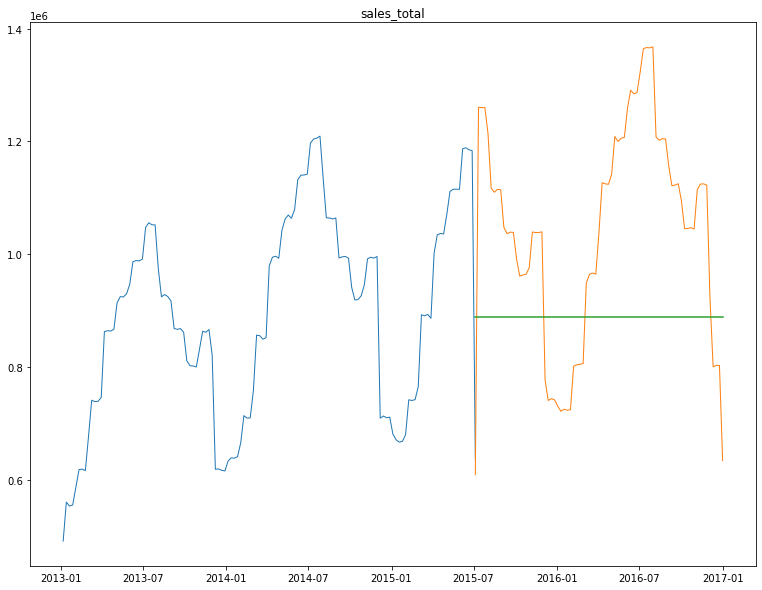

In [50]:
for col in train.columns:
    plot_and_evaluate(col)

## Create an evaluation df
- Will hold all RMSE for us to compare after we model with each type specified

In [51]:
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

In [52]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate_rmse(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [53]:
for col in train.columns:
    eval_df = append_eval_df(model_type = "simple average", target_var = col)

In [54]:
eval_df.head()

,model_type,target_var,rmse
0,simple average,items_sold,45484.0
1,simple average,sales_total,244426.0


# Moving Average

In [56]:
period = 12

items = round(train["items_sold"].rolling(period).mean().iloc[-1],2)
dollars = round(train["sales_total"].rolling(period).mean().iloc[-1], 2)

In [59]:
yhat_df = make_predictions()
yhat_df.head()

,items_sold,sales_total
sale_date,,
2015-07-05 00:00:00+00:00,201141.58,1081556.78
2015-07-12 00:00:00+00:00,201141.58,1081556.78
2015-07-19 00:00:00+00:00,201141.58,1081556.78
2015-07-26 00:00:00+00:00,201141.58,1081556.78
2015-08-02 00:00:00+00:00,201141.58,1081556.78


## Plot Actual VS Predicted 

items_sold -- RMSE: 36361


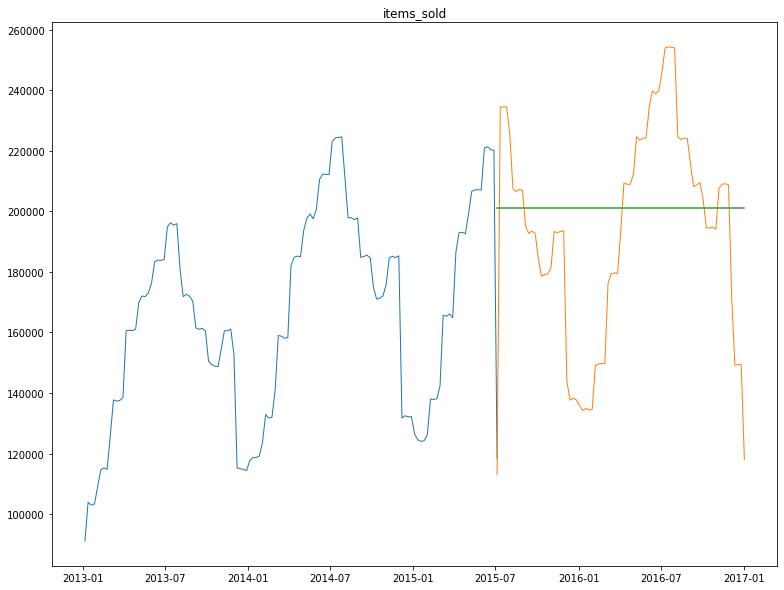

sales_total -- RMSE: 195470


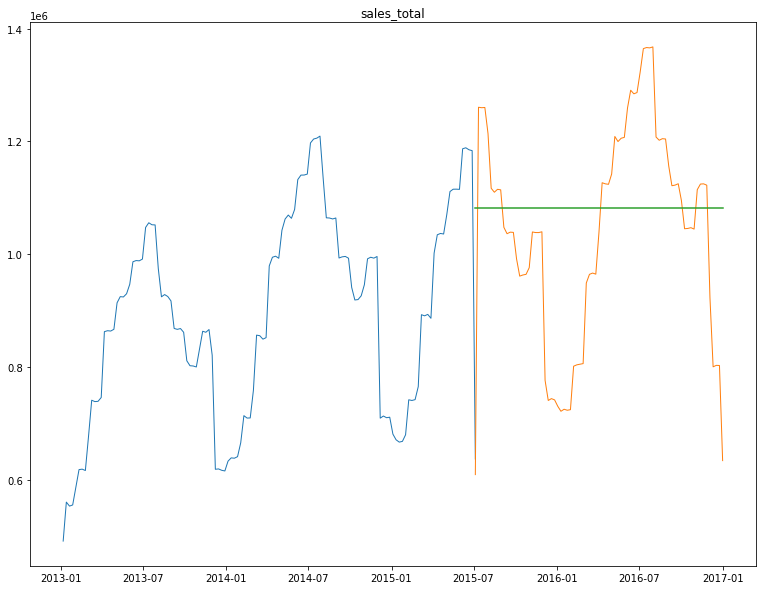

In [60]:
for col in train.columns:
    plot_and_evaluate(col)

In [63]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '12 moving average', target_var = col)

In [64]:
eval_df.head()

,model_type,target_var,rmse
0,simple average,items_sold,45484.0
1,simple average,sales_total,244426.0
2,12 moving average,items_sold,36361.0
3,12 moving average,sales_total,195470.0


# Holt's Linear Trend Model

In [ ]:
for col in train.columns:
    
    # make the thing
    model = Holt(train[col], exponential = False)
    
    # fit the thing
    model = model.fit(smoothing_level = .3, smoothing_slope = .1, optimized = False)
    
    # use the thing